In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/football-match-probability-prediction/sample_submission.csv
/kaggle/input/football-match-probability-prediction/train_target_and_scores.csv
/kaggle/input/football-match-probability-prediction/train.csv
/kaggle/input/football-match-probability-prediction/test.csv


In [2]:
#import modules
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

%matplotlib inline

#loading the data
train = pd.read_csv('/kaggle/input/football-match-probability-prediction/train.csv')
test = pd.read_csv('/kaggle/input/football-match-probability-prediction/test.csv')

/opt/conda/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3524: DtypeWarning: Columns (7) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [3]:
def is_cup_conversion(df):
    '''convert is_cup column from boolean to 0/1'''
    df.is_cup = df.is_cup.apply(lambda x: np.multiply(x, 1) )
    df['is_cup'].fillna(0, inplace=True) # missing value filled with 0, ie non-cup game
    return df

In [4]:
def has_coach_change(df):
    '''add features indicating whether home and away teams have changed coach'''
    
    df['home_has_coach_change'] = df.apply(lambda r: any([(r['home_team_coach_id']!=r[f'home_team_history_coach_{i}']) 
                                                    & (np.isnan(r[f'home_team_history_coach_{i}'])==False) for i in range(1,11) ]) , axis=1)
    df['home_has_coach_change'] = df['home_has_coach_change'].apply(lambda x: np.multiply(x, 1) )
    df['home_has_coach_change'].fillna(0, inplace=True)
    df['away_has_coach_change'] = df.apply(lambda r: any([(r['away_team_coach_id']!=r[f'away_team_history_coach_{i}']) 
                                                    & (np.isnan(r[f'away_team_history_coach_{i}'])==False) for i in range(1,11) ]) , axis=1)
    df['away_has_coach_change'] = df['away_has_coach_change'].apply(lambda x: np.multiply(x, 1) ).fillna(0, inplace=True)
    df['away_has_coach_change'].fillna(0, inplace=True)
    return df

In [5]:
feature_columns = ['id', 'match_date','league_id','is_cup','home_team_coach_id','away_team_coach_id','home_has_coach_change','away_has_coach_change']
history_columns = [col for col in train.columns if col[-1].isdigit()]

In [6]:
def convert_to_long_form(df, feature_columns, history_columns):
    '''coverting the history columns into long form, for convenience and better speed of manipulation'''
    stubname=['home_team_history_match_date',
           'home_team_history_is_play_home',
           'home_team_history_is_cup',
           'home_team_history_goal',
           'home_team_history_opponent_goal',
           'home_team_history_rating',
           'home_team_history_opponent_rating',
           'home_team_history_coach',
           'home_team_history_league_id',
           'away_team_history_match_date',
           'away_team_history_is_play_home',
           'away_team_history_is_cup',
           'away_team_history_goal',
           'away_team_history_opponent_goal',
           'away_team_history_rating',
           'away_team_history_opponent_rating',
           'away_team_history_coach',
           'away_team_history_league_id']
    df_long=pd.wide_to_long(df[feature_columns+history_columns], stubnames=stubname, i='id', j='match', sep='_')
    df_long=df_long.reset_index().sort_values(by=['id','match'])
    return df_long

In [7]:
def add_match_interval(df):
    '''add features indicating the time gaps between the match days of previous matches for the home and away teams, 
    and how long they played 3 matches and 6 matches,as an reflection of fatique factor'''
    for i in [1,2,5]:
        home_team_history_match_interval = (df.groupby('id').match_date.first().apply(pd.Timestamp) \
             - df.query('match ==1').groupby('id').home_team_history_match_date.first().apply(pd.Timestamp) ) /np.timedelta64(1, "D")
        df=df.join(home_team_history_match_interval.to_frame(name=f'home_team_history_match_interval_{i}'), on='id')
        
        away_team_history_match_interval = (df.groupby('id').match_date.first().apply(pd.Timestamp) \
             - df.query('match ==1').groupby('id').away_team_history_match_date.first().apply(pd.Timestamp) ) /np.timedelta64(1, "D")
        df=df.join(away_team_history_match_interval.to_frame(name=f'away_team_history_match_interval_{i}'), on='id')
        
    return df

In [8]:
def result_point(goal_difference):
    if goal_difference > 0:
        return 3
    elif goal_difference==0:
        return 1
    elif goal_difference < 0:
        return 0
    else:
        return np.NaN

In [9]:
def add_form_features(df):
    '''adding form features for home and away teams, including rating difference and goal difference for each previous match,
    and the average points got, average goal scored, average goal conceded and average goal difference up to that match as previous n-match form'''
    
    df['home_team_history_goal_difference']=df['home_team_history_goal']-df['home_team_history_opponent_goal']
    df['away_team_history_goal_difference']=df['away_team_history_goal']-df['away_team_history_opponent_goal']
    df['home_team_history_point']=df.home_team_history_goal_difference.apply(result_point)
    df['away_team_history_point']=df.away_team_history_goal_difference.apply(result_point)
    df['home_team_history_rating_difference']=df['home_team_history_rating']-df['home_team_history_opponent_rating']
    df['away_team_history_rating_difference']=df['away_team_history_rating']-df['away_team_history_opponent_rating']
    
    home_team_history_goal_info_available=df.groupby('id').home_team_history_goal_difference.count()
    df=df.join(home_team_history_goal_info_available.to_frame(name='home_team_history_goal_info_available'), on='id')
    away_team_history_goal_info_available=df.groupby('id').away_team_history_goal_difference.count()
    df=df.join(away_team_history_goal_info_available.to_frame(name='away_team_history_goal_info_available'), on='id')
    home_team_history_rating_info_available=df.groupby('id').home_team_history_rating_difference.count()
    df=df.join(home_team_history_rating_info_available.to_frame(name='home_team_history_rating_info_available'), on='id')
    away_team_history_rating_info_available=df.groupby('id').away_team_history_rating_difference.count()
    df=df.join(away_team_history_rating_info_available.to_frame(name='away_team_history_rating_info_available'), on='id')
    
        
    for i in [5,10]:
        home_team_history_average_goal_scored=df.query(f'match <= {i}').groupby('id').home_team_history_goal.mean()
        df=df.join(home_team_history_average_goal_scored.to_frame(name=f'home_team_history_average_goal_scored_{i}'), on='id')
        home_team_history_average_goal_conceded=df.query(f'match <= {i}').groupby('id').home_team_history_opponent_goal.mean()
        df=df.join(home_team_history_average_goal_conceded.to_frame(name=f'home_team_history_average_goal_conceded_{i}'), on='id')
        
        away_team_history_average_goal_scored=df.query(f'match <= {i}').groupby('id').away_team_history_goal.mean()
        df=df.join(away_team_history_average_goal_scored.to_frame(name=f'away_team_history_average_goal_scored_{i}'), on='id')
        away_team_history_average_goal_conceded=df.query(f'match <= {i}').groupby('id').away_team_history_opponent_goal.mean()
        df=df.join(away_team_history_average_goal_conceded.to_frame(name=f'away_team_history_average_goal_conceded_{i}'), on='id')
        
        df[f'home_team_history_average_goal_difference_{i}']=df[f'home_team_history_average_goal_scored_{i}']-df[f'home_team_history_average_goal_conceded_{i}']
        df[f'away_team_history_average_goal_difference_{i}']=df[f'away_team_history_average_goal_scored_{i}']-df[f'away_team_history_average_goal_conceded_{i}']
        
        home_team_history_average_point=df.query(f'match <= {i}').groupby('id').home_team_history_point.mean()
        df=df.join(home_team_history_average_point.to_frame(name=f'home_team_history_average_point_{i}'), on='id')
        away_team_history_average_point=df.query(f'match <= {i}').groupby('id').away_team_history_point.mean()
        df=df.join(away_team_history_average_point.to_frame(name=f'away_team_history_average_point_{i}'), on='id')
        home_team_history_average_point_std=df.query(f'match <= {i}').groupby('id').home_team_history_point.std()
        df=df.join(home_team_history_average_point_std.to_frame(name=f'home_team_history_average_point_std_{i}'), on='id')
        away_team_history_average_point_std=df.query(f'match <= {i}').groupby('id').away_team_history_point.std()
        df=df.join(away_team_history_average_point_std.to_frame(name=f'away_team_history_average_point_std_{i}'), on='id')
        
        home_team_history_median_rating_difference=df.query(f'match <= {i}').groupby('id').home_team_history_rating_difference.median()
        df=df.join(home_team_history_median_rating_difference.to_frame(name=f'home_team_history_median_rating_difference_{i}'), on='id')
        away_team_history_median_rating_difference=df.query(f'match <= {i}').groupby('id').away_team_history_rating_difference.median()
        df=df.join(away_team_history_median_rating_difference.to_frame(name=f'away_team_history_median_rating_difference_{i}'), on='id')
        home_team_history_rating_difference_std=df.query(f'match <= {i}').groupby('id').home_team_history_rating_difference.std()
        df=df.join(home_team_history_rating_difference_std.to_frame(name=f'home_team_history_rating_difference_std_{i}'), on='id')
        away_team_history_rating_difference_std=df.query(f'match <= {i}').groupby('id').away_team_history_rating_difference.std()
        df=df.join(away_team_history_rating_difference_std.to_frame(name=f'away_team_history_rating_difference_std_{i}'), on='id')
    
    home_team_home_form_average_goal_scored=df.query('home_team_history_is_play_home==1').groupby('id').home_team_history_goal.mean()
    df=df.join(home_team_home_form_average_goal_scored.to_frame(name='home_team_home_form_average_goal_scored'), on='id')
    home_team_home_form_average_goal_conceded=df.query('home_team_history_is_play_home==1').groupby('id').home_team_history_opponent_goal.mean()
    df=df.join(home_team_home_form_average_goal_conceded.to_frame(name='home_team_home_form_average_goal_conceded'), on='id')
    home_team_home_form_average_goal_difference=df.query('home_team_history_is_play_home==1').groupby('id').home_team_history_goal_difference.mean()
    df=df.join(home_team_home_form_average_goal_difference.to_frame(name='home_team_home_form_average_goal_difference'), on='id')
    home_team_home_form_goal_difference_std=df.query('home_team_history_is_play_home==1').groupby('id').home_team_history_goal_difference.std()
    df=df.join(home_team_home_form_goal_difference_std.to_frame(name='home_team_home_form_goal_difference_std'), on='id')
    home_team_home_form_win_rate=df.query('(home_team_history_is_play_home==1) & (home_team_history_point==3)').groupby('id').home_team_history_point.count()/df.query('home_team_history_is_play_home==1').groupby('id').home_team_history_is_play_home.count()
    df=df.join(home_team_home_form_win_rate.to_frame(name='home_team_home_form_win_rate'), on='id')
    home_team_home_form_draw_rate=df.query('(home_team_history_is_play_home==1) & (home_team_history_point==1)').groupby('id').home_team_history_point.count()/df.query('home_team_history_is_play_home==1').groupby('id').home_team_history_is_play_home.count()
    df=df.join(home_team_home_form_draw_rate.to_frame(name='home_team_home_form_draw_rate'), on='id')
    home_team_home_form_lose_rate=df.query('(home_team_history_is_play_home==1) & (home_team_history_point==0)').groupby('id').home_team_history_point.count()/df.query('home_team_history_is_play_home==1').groupby('id').home_team_history_is_play_home.count()
    df=df.join(home_team_home_form_lose_rate.to_frame(name='home_team_home_form_lose_rate'), on='id')
    home_team_home_form_average_point=df.query('home_team_history_is_play_home==1').groupby('id').home_team_history_point.mean()
    df=df.join(home_team_home_form_average_point.to_frame(name='home_team_home_form_average_point'), on='id')
    home_team_home_form_median_rating_difference=df.query('home_team_history_is_play_home==1').groupby('id').home_team_history_rating_difference.median()
    df=df.join(home_team_home_form_median_rating_difference.to_frame(name='home_team_home_form_median_rating_difference'), on='id')
    home_team_home_form_goal_info_available=df.query('home_team_history_is_play_home==1').groupby('id').home_team_history_goal_difference.count()
    df=df.join(home_team_home_form_goal_info_available.to_frame(name='home_team_home_form_goal_info_available'), on='id')
    home_team_home_form_rating_info_available=df.query('home_team_history_is_play_home==1').groupby('id').home_team_history_rating_difference.count()
    df=df.join(home_team_home_form_rating_info_available.to_frame(name='home_team_home_form_rating_info_available'), on='id')
    
    away_team_away_form_average_goal_scored=df.query('away_team_history_is_play_home==0').groupby('id').away_team_history_goal.mean()
    df=df.join(away_team_away_form_average_goal_scored.to_frame(name='away_team_away_form_average_goal_scored'), on='id')
    away_team_away_form_average_goal_conceded=df.query('away_team_history_is_play_home==0').groupby('id').away_team_history_opponent_goal.mean()
    df=df.join(away_team_away_form_average_goal_conceded.to_frame(name='away_team_away_form_average_goal_conceded'), on='id')
    away_team_away_form_average_goal_difference=df.query('away_team_history_is_play_home==0').groupby('id').away_team_history_goal_difference.mean()
    df=df.join(away_team_away_form_average_goal_difference.to_frame(name='away_team_away_form_average_goal_difference'), on='id')
    away_team_away_form_goal_difference_std=df.query('away_team_history_is_play_home==0').groupby('id').away_team_history_goal_difference.std()
    df=df.join(away_team_away_form_goal_difference_std.to_frame(name='away_team_away_form_goal_difference_std'), on='id')
    away_team_away_form_win_rate=df.query('(away_team_history_is_play_home==0) & (away_team_history_point==3)').groupby('id').away_team_history_point.count()/df.query('away_team_history_is_play_home==0').groupby('id').away_team_history_is_play_home.count()
    df=df.join(away_team_away_form_win_rate.to_frame(name='away_team_away_form_win_rate'), on='id')
    away_team_away_form_draw_rate=df.query('(away_team_history_is_play_home==0) & (away_team_history_point==1)').groupby('id').away_team_history_point.count()/df.query('away_team_history_is_play_home==0').groupby('id').away_team_history_is_play_home.count()
    df=df.join(away_team_away_form_draw_rate.to_frame(name='away_team_away_form_draw_rate'), on='id')
    away_team_away_form_lose_rate=df.query('(away_team_history_is_play_home==0) & (away_team_history_point==0)').groupby('id').away_team_history_point.count()/df.query('away_team_history_is_play_home==0').groupby('id').away_team_history_is_play_home.count()
    df=df.join(away_team_away_form_lose_rate.to_frame(name='away_team_away_form_lose_rate'), on='id')
    away_team_away_form_average_point=df.query('away_team_history_is_play_home==0').groupby('id').away_team_history_point.mean()
    df=df.join(away_team_away_form_average_point.to_frame(name='away_team_away_form_average_point'), on='id')
    away_team_away_form_median_rating_difference=df.query('away_team_history_is_play_home==0').groupby('id').away_team_history_rating_difference.median()
    df=df.join(away_team_away_form_median_rating_difference.to_frame(name='away_team_away_form_median_rating_difference'), on='id')
    away_team_away_form_goal_info_available=df.query('away_team_history_is_play_home==0').groupby('id').away_team_history_goal_difference.count()
    df=df.join(away_team_away_form_goal_info_available.to_frame(name='away_team_away_form_goal_info_available'), on='id')
    away_team_away_form_rating_info_available=df.query('away_team_history_is_play_home==0').groupby('id').away_team_history_rating_difference.count()
    df=df.join(away_team_away_form_rating_info_available.to_frame(name='away_team_away_form_rating_info_available'), on='id')
    
    return df

In [10]:
def add_attack_defense_strength_features(df):
    '''getting goal rates of the league/competition, and calculate the attack and defense strength of a team relative to the league/competition,
    and the expected goals based on this'''
    
    home_history_columns=['home_team_history_match_date',
           'home_team_history_is_play_home',
           'home_team_history_is_cup',
           'home_team_history_goal',
           'home_team_history_opponent_goal',
           'home_team_history_rating',
           'home_team_history_opponent_rating',
           'home_team_history_coach',
           'home_team_history_league_id']
    home_history=df[home_history_columns]
    home_history=home_history.drop_duplicates()
    
    away_history_columns=['away_team_history_match_date',
           'away_team_history_is_play_home',
           'away_team_history_is_cup',
           'away_team_history_goal',
           'away_team_history_opponent_goal',
           'away_team_history_rating',
           'away_team_history_opponent_rating',
           'away_team_history_coach',
           'away_team_history_league_id']
    away_history=df[away_history_columns]
    away_history=away_history.drop_duplicates()
    
    league_total_goal = home_history.groupby('home_team_history_league_id').home_team_history_goal.sum() \
                    + home_history.groupby('home_team_history_league_id').home_team_history_opponent_goal.sum() \
                    + away_history.groupby('away_team_history_league_id').away_team_history_goal.sum() \
                    + away_history.groupby('away_team_history_league_id').away_team_history_opponent_goal.sum()
    league_total_game = home_history.groupby('home_team_history_league_id').home_team_history_goal.count() \
                    + home_history.groupby('home_team_history_league_id').home_team_history_opponent_goal.count() \
                    + away_history.groupby('away_team_history_league_id').away_team_history_goal.count() \
                    + away_history.groupby('away_team_history_league_id').away_team_history_opponent_goal.count() 
    league_average_goal = league_total_goal/league_total_game
    df=df.join(league_average_goal.to_frame(name='league_average_goal'), on='league_id')
    df.league_average_goal=df.league_average_goal.fillna(df.league_average_goal.mean())
    
    league_total_home_goal = home_history.query('home_team_history_is_play_home==1').groupby('home_team_history_league_id').home_team_history_goal.sum() \
                    + home_history.query('home_team_history_is_play_home==0').groupby('home_team_history_league_id').home_team_history_opponent_goal.sum() \
                    + away_history.query('away_team_history_is_play_home==1').groupby('away_team_history_league_id').away_team_history_goal.sum() \
                    + away_history.query('away_team_history_is_play_home==0').groupby('away_team_history_league_id').away_team_history_opponent_goal.sum()
    league_total_home_goal_game = home_history.query('home_team_history_is_play_home==1').groupby('home_team_history_league_id').home_team_history_goal.count() \
                    + home_history.query('home_team_history_is_play_home==0').groupby('home_team_history_league_id').home_team_history_opponent_goal.count() \
                    + away_history.query('away_team_history_is_play_home==1').groupby('away_team_history_league_id').away_team_history_goal.count() \
                    + away_history.query('away_team_history_is_play_home==0').groupby('away_team_history_league_id').away_team_history_opponent_goal.count()
    league_average_home_goal = league_total_home_goal/league_total_home_goal_game
    df=df.join(league_average_home_goal.to_frame(name='league_average_home_goal'), on='league_id')
    df.league_average_home_goal=df.league_average_home_goal.fillna(df.league_average_home_goal.mean())
    
    league_total_away_goal = home_history.query('home_team_history_is_play_home==0').groupby('home_team_history_league_id').home_team_history_goal.sum() \
                    + home_history.query('home_team_history_is_play_home==1').groupby('home_team_history_league_id').home_team_history_opponent_goal.sum() \
                    + away_history.query('away_team_history_is_play_home==0').groupby('away_team_history_league_id').away_team_history_goal.sum() \
                    + away_history.query('away_team_history_is_play_home==1').groupby('away_team_history_league_id').away_team_history_opponent_goal.sum()
    league_total_away_goal_game = home_history.query('home_team_history_is_play_home==0').groupby('home_team_history_league_id').home_team_history_goal.count() \
                    + home_history.query('home_team_history_is_play_home==1').groupby('home_team_history_league_id').home_team_history_opponent_goal.count() \
                    + away_history.query('away_team_history_is_play_home==0').groupby('away_team_history_league_id').away_team_history_goal.count() \
                    + away_history.query('away_team_history_is_play_home==1').groupby('away_team_history_league_id').away_team_history_opponent_goal.count()
    league_average_away_goal = league_total_away_goal/league_total_away_goal_game
    df=df.join(league_average_away_goal.to_frame(name='league_average_away_goal'), on='league_id')
    df.league_average_away_goal=df.league_average_away_goal.fillna(df.league_average_away_goal.mean())
    
    df['home_team_attack_strength'] = df.home_team_history_average_goal_scored_10/df.league_average_goal
    df['home_team_defense_strength'] = df.home_team_history_average_goal_conceded_10/df.league_average_goal
    df['away_team_attack_strength'] = df.away_team_history_average_goal_scored_10/df.league_average_goal
    df['away_team_defense_strength'] = df.away_team_history_average_goal_conceded_10/df.league_average_goal
    df['home_team_expected_goal'] = df.league_average_home_goal*df.home_team_attack_strength*df.away_team_defense_strength
    df['away_team_expected_goal'] = df.league_average_away_goal*df.away_team_attack_strength*df.home_team_defense_strength
    
    
    #getting coach's record of goal scored and conceded in each league
    home_team_coach_league_average_goal_scored=home_history.groupby(['home_team_history_coach','home_team_history_league_id']).home_team_history_goal.agg(['mean','count']).reset_index()
    home_team_coach_league_average_goal_scored=home_team_coach_league_average_goal_scored.query('count > 9').drop('count', axis=1)
    home_team_coach_league_average_goal_scored.columns=['home_team_coach_id','league_id','home_team_coach_league_average_goal_scored']
    df=pd.merge(df, home_team_coach_league_average_goal_scored, how='left')
    
    home_team_coach_league_average_goal_conceded=home_history.groupby(['home_team_history_coach','home_team_history_league_id']).home_team_history_opponent_goal.agg(['mean','count']).reset_index() 
    home_team_coach_league_average_goal_conceded=home_team_coach_league_average_goal_conceded.query('count > 9').drop('count', axis=1)
    home_team_coach_league_average_goal_conceded.columns=['home_team_coach_id','league_id','home_team_coach_league_average_goal_conceded']
    df=pd.merge(df, home_team_coach_league_average_goal_conceded, how='left')
    
    away_team_coach_league_average_goal_scored=away_history.groupby(['away_team_history_coach','away_team_history_league_id']).away_team_history_goal.agg(['mean','count']).reset_index()
    away_team_coach_league_average_goal_scored=away_team_coach_league_average_goal_scored.query('count > 9').drop('count', axis=1)
    away_team_coach_league_average_goal_scored.columns=['away_team_coach_id','league_id','away_team_coach_league_average_goal_scored']
    df=pd.merge(df, away_team_coach_league_average_goal_scored, how='left')
    
    away_team_coach_league_average_goal_conceded=away_history.groupby(['away_team_history_coach','away_team_history_league_id']).away_team_history_opponent_goal.agg(['mean','count']).reset_index()
    away_team_coach_league_average_goal_conceded=away_team_coach_league_average_goal_conceded.query('count > 9').drop('count', axis=1)
    away_team_coach_league_average_goal_conceded.columns=['away_team_coach_id','league_id','away_team_coach_league_average_goal_conceded']
    df=pd.merge(df, away_team_coach_league_average_goal_conceded, how='left')
    
    #setting another set of attack, defense and expected goal data based on coach's record
    df['home_team_coach_attack_strength'] = df.home_team_coach_league_average_goal_scored/df.league_average_goal
    df['home_team_coach_defense_strength'] = df.home_team_coach_league_average_goal_conceded/df.league_average_goal
    df['away_team_coach_attack_strength'] = df.away_team_coach_league_average_goal_scored/df.league_average_goal
    df['away_team_coach_defense_strength'] = df.away_team_coach_league_average_goal_conceded/df.league_average_goal
    df['home_team_coach_expected_goal'] = df.league_average_home_goal*df.home_team_coach_attack_strength*df.away_team_coach_defense_strength
    df['away_team_coach_expected_goal'] = df.league_average_away_goal*df.away_team_coach_attack_strength*df.home_team_coach_defense_strength
    return df

In [11]:
def preprocession(df):
    df=is_cup_conversion(df)
    df=has_coach_change(df)
    df=convert_to_long_form(df, feature_columns, history_columns)
    df=add_match_interval(df)
    df=add_form_features(df)
    df=add_attack_defense_strength_features(df)
    df.replace([np.inf, -np.inf], np.nan, inplace=True)
    df=df.groupby('id').first().reset_index()

    return df

In [12]:
train_p=preprocession(train)

In [13]:
for i in train_p.columns:
    print(i, train_p.loc[467,i])

id 11864226
match 1
league_id 453
home_has_coach_change 0
is_cup 0.0
away_team_coach_id 458731.0
match_date 2020-05-31 15:30:00
away_has_coach_change 0
home_team_coach_id 456984.0
home_team_history_match_date 2020-03-11 17:00:00
home_team_history_is_play_home 1.0
home_team_history_is_cup 1.0
home_team_history_goal 2.0
home_team_history_opponent_goal 1.0
home_team_history_rating 6.494562500000001
home_team_history_opponent_rating 4.910825
home_team_history_coach 456984.0
home_team_history_league_id 459.0
away_team_history_match_date 2020-03-07 14:00:00
away_team_history_is_play_home 1.0
away_team_history_is_cup 0.0
away_team_history_goal 1.0
away_team_history_opponent_goal 2.0
away_team_history_rating 7.1570375
away_team_history_opponent_rating 4.701475
away_team_history_coach 2510382.0
away_team_history_league_id 453.0
home_team_history_match_interval_1 80.9375
away_team_history_match_interval_1 85.0625
home_team_history_match_interval_2 80.9375
away_team_history_match_interval_2 85.06

In [14]:
train_p

,id,match,league_id,home_has_coach_change,is_cup,away_team_coach_id,match_date,away_has_coach_change,home_team_coach_id,home_team_history_match_date,...,home_team_coach_league_average_goal_scored,home_team_coach_league_average_goal_conceded,away_team_coach_league_average_goal_scored,away_team_coach_league_average_goal_conceded,home_team_coach_attack_strength,home_team_coach_defense_strength,away_team_coach_attack_strength,away_team_coach_defense_strength,home_team_coach_expected_goal,away_team_coach_expected_goal
0,11428294,1,755,1,0.0,257433.0,2019-12-03 23:00:00,0,468693.0,2019-11-27 21:00:00,...,0.901961,1.431373,1.022727,1.681818,0.685099,1.087222,0.776829,1.277452,1.206828,1.059224
1,11428295,1,755,1,0.0,16476269.0,2019-12-01 23:00:00,0,37331516.0,2019-11-27 23:00:00,...,NaN,NaN,1.727273,0.545455,NaN,NaN,1.311978,0.414309,NaN,NaN
2,11428297,1,755,1,0.0,474745.0,2019-12-02 21:00:00,0,212710.0,2019-11-28 23:00:00,...,NaN,NaN,1.500000,1.000000,NaN,NaN,1.139349,0.759566,NaN,NaN
3,11428298,1,755,0,0.0,472575.0,2019-12-01 23:00:00,0,186127.0,2019-11-27 21:00:00,...,1.296296,1.518519,2.048387,1.000000,0.984623,1.153415,1.555885,0.759566,1.031295,2.250648
4,11428299,1,755,0,0.0,216631.0,2019-12-01 21:00:00,0,470514.0,2019-11-28 21:00:00,...,1.315789,1.000000,1.142857,1.214286,0.999429,0.759566,0.868075,0.922330,1.271118,0.826927
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
110933,18045358,1,827,1,0.0,NaN,2021-04-29 18:00:00,0,NaN,2021-04-25 16:00:00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
110934,18046139,1,974,1,0.0,1552546.0,2021-04-30 10:00:00,0,37568493.0,2021-03-04 12:15:00,...,NaN,NaN,2.357143,0.714286,NaN,NaN,1.553857,0.470866,NaN,NaN
110935,18046140,1,974,0,0.0,17905337.0,2021-04-30 13:00:00,0,22859379.0,2021-03-04 09:45:00,...,1.166667,1.833333,2.153846,1.076923,0.769081,1.208555,1.419841,0.709921,0.886456,2.420081
110936,18046141,1,974,1,0.0,2206663.0,2021-04-30 15:00:00,0,29328646.0,2021-03-05 10:00:00,...,0.782609,2.043478,1.592593,1.296296,0.515905,1.347085,1.049856,0.854534,0.715772,1.994566


In [15]:
drop_columns=['id',
              'match',
              'match_date',
              'league_id',
              'home_team_coach_id',
              'away_team_coach_id',
              'home_team_history_match_date',
              'home_team_history_is_play_home',
              'home_team_history_is_cup',
              'home_team_history_goal',
              'home_team_history_opponent_goal',
              'home_team_history_rating',
              'home_team_history_opponent_rating',
              'home_team_history_coach',
              'home_team_history_league_id',
              'away_team_history_match_date',
              'away_team_history_is_play_home',
              'away_team_history_is_cup',
              'away_team_history_goal',
              'away_team_history_opponent_goal',
              'away_team_history_rating',
              'away_team_history_opponent_rating',
              'away_team_history_coach',
              'away_team_history_league_id']

In [16]:
X=train_p.drop(drop_columns, axis=1)
y=train.sort_values(by='id')['target']

In [17]:
X

,home_has_coach_change,is_cup,away_has_coach_change,home_team_history_match_interval_1,away_team_history_match_interval_1,home_team_history_match_interval_2,away_team_history_match_interval_2,home_team_history_match_interval_5,away_team_history_match_interval_5,home_team_history_goal_difference,...,home_team_coach_league_average_goal_scored,home_team_coach_league_average_goal_conceded,away_team_coach_league_average_goal_scored,away_team_coach_league_average_goal_conceded,home_team_coach_attack_strength,home_team_coach_defense_strength,away_team_coach_attack_strength,away_team_coach_defense_strength,home_team_coach_expected_goal,away_team_coach_expected_goal
0,1,0.0,0,6.083333,5.083333,6.083333,5.083333,6.083333,5.083333,0.0,...,0.901961,1.431373,1.022727,1.681818,0.685099,1.087222,0.776829,1.277452,1.206828,1.059224
1,1,0.0,0,4.000000,4.083333,4.000000,4.083333,4.000000,4.083333,1.0,...,NaN,NaN,1.727273,0.545455,NaN,NaN,1.311978,0.414309,NaN,NaN
2,1,0.0,0,3.916667,6.000000,3.916667,6.000000,3.916667,6.000000,-1.0,...,NaN,NaN,1.500000,1.000000,NaN,NaN,1.139349,0.759566,NaN,NaN
3,0,0.0,0,4.083333,3.000000,4.083333,3.000000,4.083333,3.000000,-1.0,...,1.296296,1.518519,2.048387,1.000000,0.984623,1.153415,1.555885,0.759566,1.031295,2.250648
4,0,0.0,0,3.000000,4.000000,3.000000,4.000000,3.000000,4.000000,3.0,...,1.315789,1.000000,1.142857,1.214286,0.999429,0.759566,0.868075,0.922330,1.271118,0.826927
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
110933,1,0.0,0,4.083333,11.104167,4.083333,11.104167,4.083333,11.104167,-1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
110934,1,0.0,0,56.906250,61.000000,56.906250,61.000000,56.906250,61.000000,-1.0,...,NaN,NaN,2.357143,0.714286,NaN,NaN,1.553857,0.470866,NaN,NaN
110935,0,0.0,0,57.135417,57.031250,57.135417,57.031250,57.135417,57.031250,-5.0,...,1.166667,1.833333,2.153846,1.076923,0.769081,1.208555,1.419841,0.709921,0.886456,2.420081
110936,1,0.0,0,56.208333,57.218750,56.208333,57.218750,56.208333,57.218750,-4.0,...,0.782609,2.043478,1.592593,1.296296,0.515905,1.347085,1.049856,0.854534,0.715772,1.994566


In [18]:
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
label_encoder = label_encoder.fit(y)
label_encoded_y = label_encoder.transform(y)

In [19]:
from sklearn import model_selection
X_train, X_valid, y_train, y_valid = model_selection.train_test_split(X, label_encoded_y, train_size=0.8, random_state=42)

In [20]:
import xgboost as xgb
d_train = xgb.DMatrix(X_train, y_train)
d_test = xgb.DMatrix(X_valid, y_valid)

In [21]:
params_1 = {
    'booster': 'gbtree',
    'max_depth': 5, 
    'learning_rate': 0.025,
    'min_split_loss': 0.01,
    'min_child_weight': 5,
    'subsample': 0.8,
    'colsample_bytree': 0.25,
    'alpha': 2,
    'lambda': 3,
    'objective': 'multi:softprob',
    'num_class': 3,
    'eval_metric':'mlogloss'
    }

num_round = 1000
evallist = [(d_train, 'train'), (d_test, 'eval')]

In [22]:
bst = xgb.train(params_1, d_train, num_round, evallist, early_stopping_rounds=20)

[0]	train-mlogloss:1.09518	eval-mlogloss:1.09527
[1]	train-mlogloss:1.09217	eval-mlogloss:1.09245
[2]	train-mlogloss:1.08906	eval-mlogloss:1.08947
[3]	train-mlogloss:1.08598	eval-mlogloss:1.08655
[4]	train-mlogloss:1.08299	eval-mlogloss:1.08367
[5]	train-mlogloss:1.07989	eval-mlogloss:1.08064
[6]	train-mlogloss:1.07726	eval-mlogloss:1.07813
[7]	train-mlogloss:1.07459	eval-mlogloss:1.07559
[8]	train-mlogloss:1.07178	eval-mlogloss:1.07290
[9]	train-mlogloss:1.06931	eval-mlogloss:1.07054
[10]	train-mlogloss:1.06665	eval-mlogloss:1.06800
[11]	train-mlogloss:1.06448	eval-mlogloss:1.06592
[12]	train-mlogloss:1.06232	eval-mlogloss:1.06393
[13]	train-mlogloss:1.05994	eval-mlogloss:1.06167
[14]	train-mlogloss:1.05755	eval-mlogloss:1.05942
[15]	train-mlogloss:1.05569	eval-mlogloss:1.05770
[16]	train-mlogloss:1.05378	eval-mlogloss:1.05594
[17]	train-mlogloss:1.05185	eval-mlogloss:1.05411
[18]	train-mlogloss:1.04984	eval-mlogloss:1.05222
[19]	train-mlogloss:1.04809	eval-mlogloss:1.05054
[20]	train

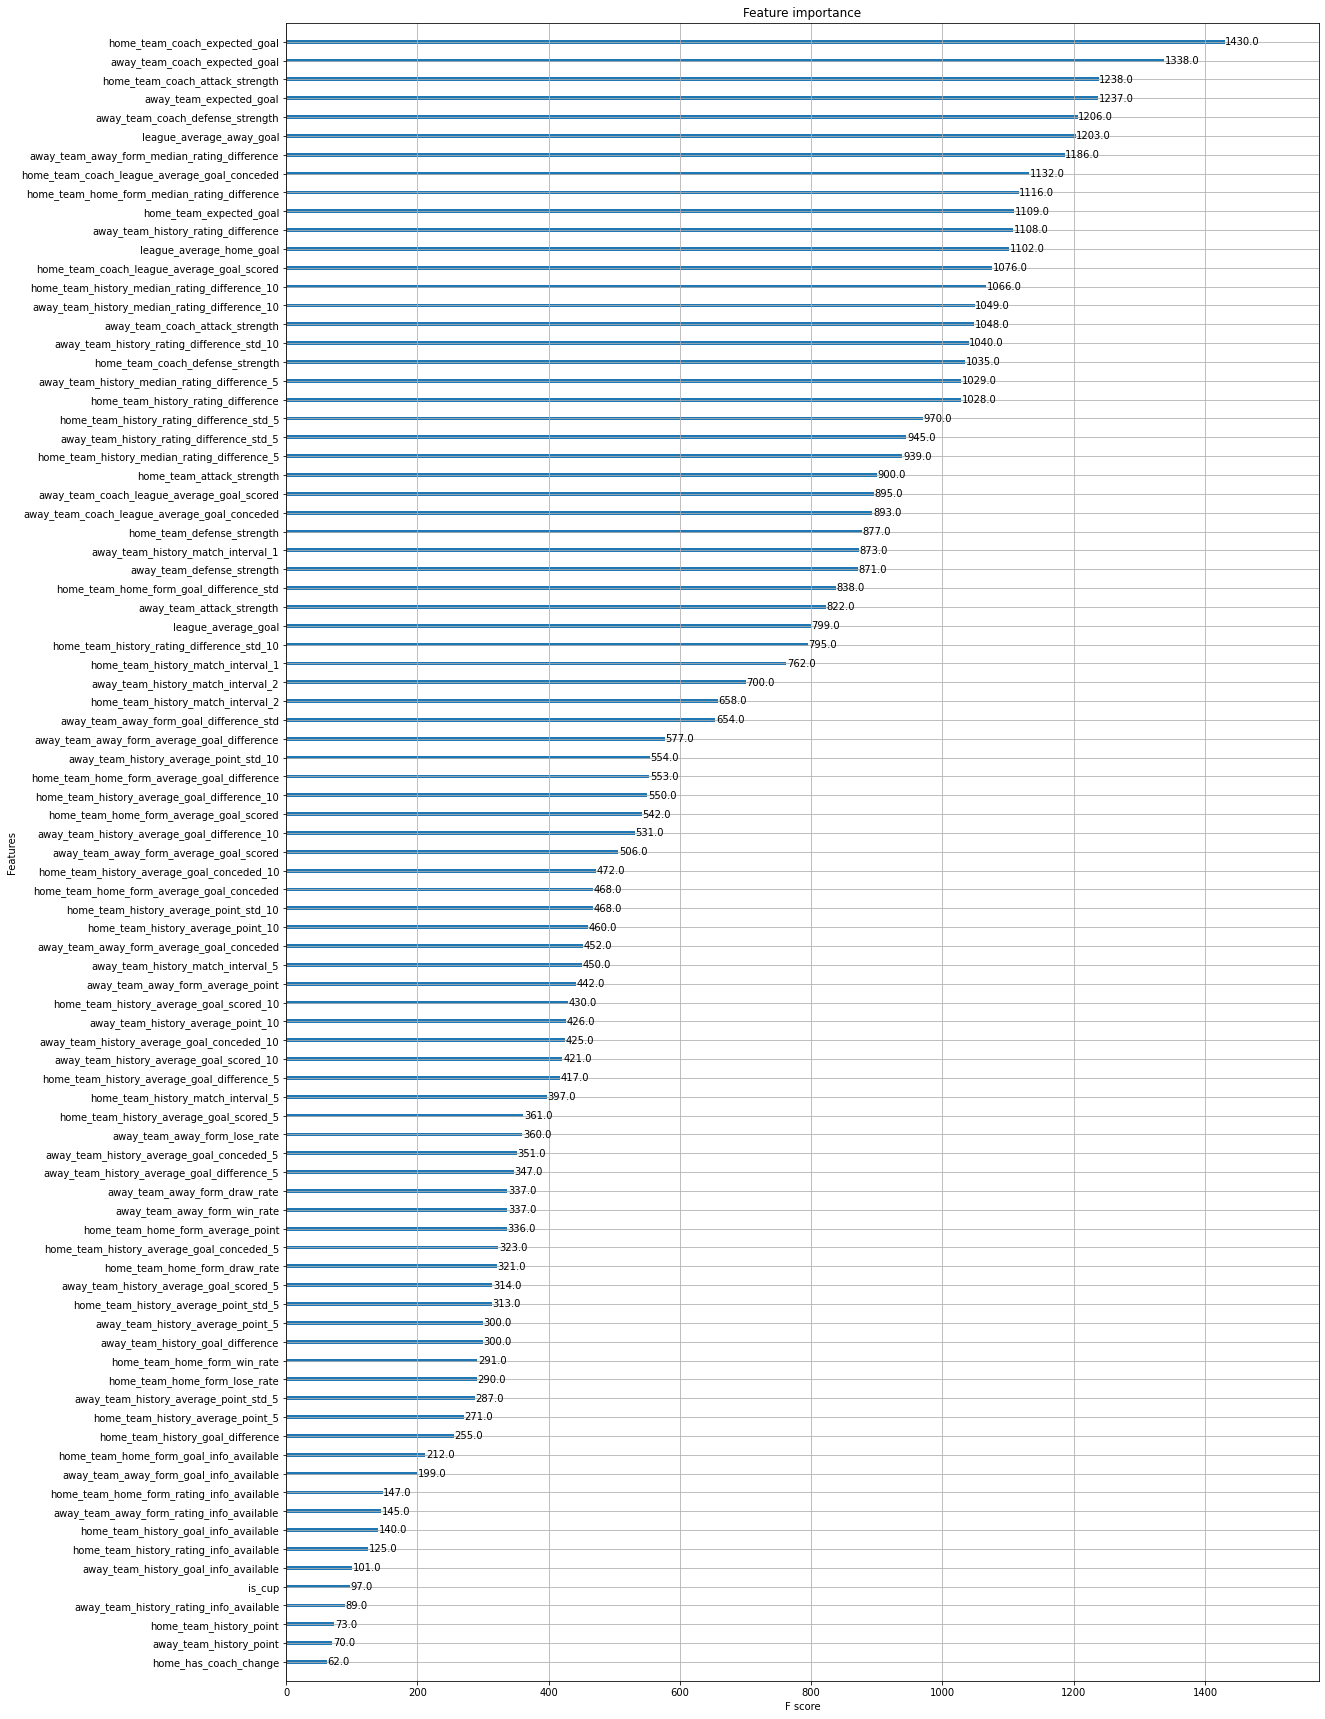

In [23]:
xgb.plot_importance(bst, max_num_features=200)
fig = plt.gcf()
fig.set_size_inches(18.5, 30.5)

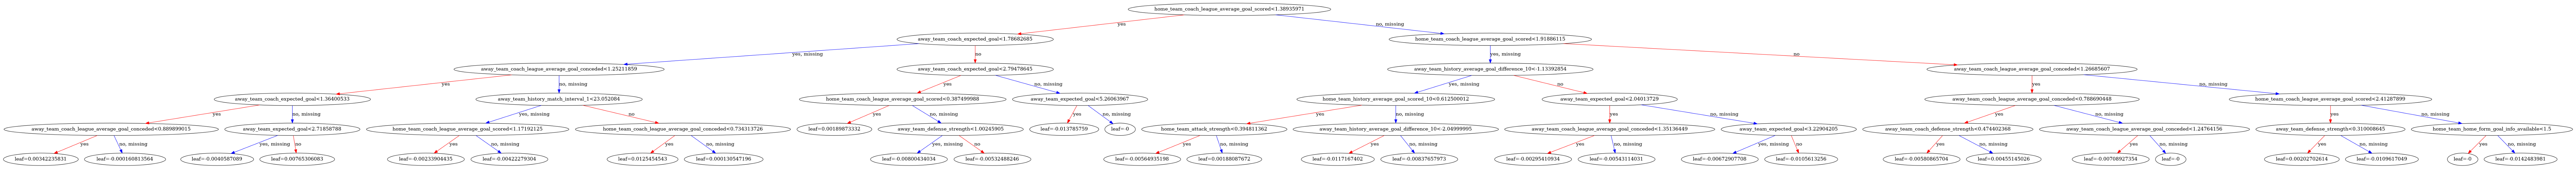

In [24]:
xgb.plot_tree(bst, num_trees=1)
fig = plt.gcf()
fig.set_size_inches(160, 100)

In [25]:
bst.best_iteration

598

In [26]:
bst.best_score

0.979743

In [27]:
test_p=preprocession(test)

In [28]:
test_p

,id,match,league_id,home_has_coach_change,is_cup,away_team_coach_id,match_date,away_has_coach_change,home_team_coach_id,home_team_history_match_date,...,home_team_coach_league_average_goal_scored,home_team_coach_league_average_goal_conceded,away_team_coach_league_average_goal_scored,away_team_coach_league_average_goal_conceded,home_team_coach_attack_strength,home_team_coach_defense_strength,away_team_coach_attack_strength,away_team_coach_defense_strength,home_team_coach_expected_goal,away_team_coach_expected_goal
0,11913628,1,714,1,1,1565666.0,2021-06-07 14:00:00,0,37570473.0,2021-05-30 11:30:00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,11913633,1,714,1,1,1565613.0,2021-06-11 17:00:00,0,311388.0,2021-06-07 17:00:00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,11913634,1,714,1,1,37570473.0,2021-06-11 14:00:00,0,8055515.0,2021-06-07 17:00:00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,11913635,1,714,1,1,1565666.0,2021-06-04 16:00:00,0,1565613.0,2019-11-19 11:00:00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,11913636,1,714,1,1,311388.0,2021-05-30 11:30:00,0,37570473.0,2019-11-19 11:00:00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
72706,18450343,1,1393,0,1,458369.0,2021-11-30 13:00:00,0,37346872.0,2021-11-26 13:00:00,...,1.700000,0.600000,1.900000,0.200000,1.207540,0.426190,1.349603,0.142063,0.277926,0.687655
72707,18450597,1,857,0,0,NaN,2021-11-27 16:00:00,0,NaN,2021-11-23 16:00:00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
72708,18450602,1,857,0,0,37369407.0,2021-11-29 16:00:00,0,NaN,2021-11-21 16:00:00,...,NaN,NaN,1.142857,0.428571,NaN,NaN,1.152722,0.432271,NaN,NaN
72709,18450640,1,779,0,0,524071.0,2021-11-28 20:00:00,0,524398.0,2021-11-20 22:00:00,...,1.780488,1.195122,1.363636,1.727273,1.266717,0.850262,0.970150,1.228857,2.587164,0.947904


In [29]:
X_test=test_p.drop(drop_columns, axis=1)
X_test_d = xgb.DMatrix(X_test)

In [30]:
X_test

,home_has_coach_change,is_cup,away_has_coach_change,home_team_history_match_interval_1,away_team_history_match_interval_1,home_team_history_match_interval_2,away_team_history_match_interval_2,home_team_history_match_interval_5,away_team_history_match_interval_5,home_team_history_goal_difference,...,home_team_coach_league_average_goal_scored,home_team_coach_league_average_goal_conceded,away_team_coach_league_average_goal_scored,away_team_coach_league_average_goal_conceded,home_team_coach_attack_strength,home_team_coach_defense_strength,away_team_coach_attack_strength,away_team_coach_defense_strength,home_team_coach_expected_goal,away_team_coach_expected_goal
0,1,1,0,8.104167,2.916667,8.104167,2.916667,8.104167,2.916667,-7.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,1,0,4.000000,7.041667,4.000000,7.041667,4.000000,7.041667,2.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1,1,0,3.875000,4.000000,3.875000,4.000000,3.875000,4.000000,-2.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1,1,0,563.208333,66.125000,563.208333,66.125000,563.208333,66.125000,2.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1,1,0,558.020833,529.177083,558.020833,529.177083,558.020833,529.177083,-2.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
72706,0,1,0,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,0.0,...,1.700000,0.600000,1.900000,0.200000,1.207540,0.426190,1.349603,0.142063,0.277926,0.687655
72707,0,0,0,4.000000,8.000000,4.000000,8.000000,4.000000,8.000000,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
72708,0,0,0,8.000000,4.000000,8.000000,4.000000,8.000000,4.000000,0.0,...,NaN,NaN,1.142857,0.428571,NaN,NaN,1.152722,0.432271,NaN,NaN
72709,0,0,0,7.916667,4.687500,7.916667,4.687500,7.916667,4.687500,2.0,...,1.780488,1.195122,1.363636,1.727273,1.266717,0.850262,0.970150,1.228857,2.587164,0.947904


In [31]:
predictions = bst.predict(X_test_d, iteration_range=(0, bst.best_iteration))

In [32]:
predictions

array([[0.65036327, 0.15899226, 0.19064446],
       [0.07159403, 0.0837066 , 0.8446994 ],
       [0.18515725, 0.0990554 , 0.71578735],
       ...,
       [0.49015266, 0.31643453, 0.19341286],
       [0.11472345, 0.16538869, 0.71988785],
       [0.33043164, 0.2775281 , 0.3920402 ]], dtype=float32)

In [33]:
submission = pd.DataFrame(predictions ,columns=label_encoder.inverse_transform([0,1,2]))
submission['id'] = test.sort_values(by='id').reset_index()['id']
cols=['id','home','away','draw']
submission=submission[cols]
display(submission)

,id,home,away,draw
0,11913628,0.190644,0.650363,0.158992
1,11913633,0.844699,0.071594,0.083707
2,11913634,0.715787,0.185157,0.099055
3,11913635,0.341543,0.444467,0.213990
4,11913636,0.149204,0.660163,0.190633
...,...,...,...,...
72706,18450343,0.206194,0.475293,0.318513
72707,18450597,0.372480,0.255729,0.371791
72708,18450602,0.193413,0.490153,0.316435
72709,18450640,0.719888,0.114723,0.165389


In [34]:
submission.to_csv('submission.csv', index=False)